In [1]:
from functools import partial
from itertools import product
from pathlib import Path
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import polaris as po
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import Draw, PandasTools
from rdkit.Chem.Draw.MolDrawing import DrawingOptions
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.SimDivFilters import MaxMinPicker
from rdkit import RDLogger
import seaborn as sns
import umap

sys.path.insert(0, '../agenticadmet')
from utils import ECFP_from_smiles, tanimoto_similarity, standardize

[23:50:49] Initializing Normalizer


In [2]:
logger = RDLogger.logger()
logger.setLevel(RDLogger.CRITICAL)

In [3]:
DATA_PATH = Path('../data/asap/raw/biogen-adme-fang-v1.tsv')
RANDOM_STATE = 42

In [4]:
def download_dataset(data_path):
    # Load the dataset from the Hub
    dataset = po.load_dataset("biogen/adme-fang-v1")

    # Get information on the dataset size
    dataset.size()

    # Load a datapoint in memory
    dataset.get_data(
        row=dataset.rows[0],
        col=dataset.columns[0],
    )

    data = []
    for i in range(len(dataset)):
        data.append(dataset[i])
    data = pd.DataFrame(data)

    data.to_csv(data_path, sep='\t', index=False)

In [5]:
if not DATA_PATH.exists():
    download_dataset(DATA_PATH)
data = pd.read_csv(DATA_PATH, sep='\t')
data

,UNIQUE_ID,MOL_smiles,SMILES,LOG_HLM_CLint,LOG_RLM_CLint,LOG_MDR1-MDCK_ER,LOG_HPPB,LOG_RPPB,LOG_SOLUBILITY
0,b5e1231aef0080c76b4207ca1355485432877339,Brc1cc2c(cc1Cn1cncn1)OCCCO2,Brc1cc2c(cc1Cn1cncn1)OCCCO2,0.886265,2.357933,-0.247518,NaN,NaN,1.536432
1,0604cf74e44450d5963d169e18854d96c4e5dba8,Brc1ccc(-c2nnc(Cn3cnc4ccccc43)o2)o1,Brc1ccc(-c2nnc(Cn3cnc4ccccc43)o2)o1,0.675687,1.613704,-0.010669,NaN,NaN,1.797475
2,c518badac8533fdb0de4679c17ce4035eab9ac28,Brc1cnc(N2CCCN(c3ccccc3)CC2)nc1,Brc1cnc(N2CCCN(c3ccccc3)CC2)nc1,2.081607,3.753651,NaN,NaN,NaN,NaN
3,9be43035e7b8a5078babf4345584f4dc6dcd1448,Brc1cnc2ccccc2c1,Brc1cnc2ccccc2c1,NaN,NaN,NaN,NaN,NaN,-0.033858
4,57b907f2f455c3ce3ba21114f32f93b301c99a34,Brc1nnc(N2CCC(OC3CCCC3)CC2)s1,Brc1nnc(N2CCC(OC3CCCC3)CC2)s1,1.888410,3.492201,-0.235024,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
3516,6170f36d417c6cebd1a98e82f03005da39ccc983,c1nc(N2CCC3(CCCCC3)C2)c2cn[nH]c2n1,c1nc(N2CCC3(CCCCC3)C2)c2cn[nH]c2n1,0.920801,2.851225,-0.096904,NaN,NaN,NaN
3517,644313d1941ab4550760b7c1162c54d209a7435f,c1nc(NC2CCN(C3CC3)CC2)c2sccc2n1,c1nc(NC2CCN(C3CC3)CC2)c2sccc2n1,1.240899,1.906157,0.094514,NaN,NaN,1.749891
3518,32658afab9952faf20249dbb305e1ac85ef10a1b,c1nc(Nc2ccc3c(c2)OCCCO3)c2sccc2n1,c1nc(Nc2ccc3c(c2)OCCCO3)c2sccc2n1,1.964066,3.196559,NaN,NaN,NaN,1.707229
3519,de4a8fd15738b6f012f58b93bb6784afc82f9742,c1nn(C2CCOCC2)cc1Nc1ncc2nnn(-c3ccc4cn[nH]c4c3)...,c1nn(C2CCOCC2)cc1Nc1ncc2nnn(-c3ccc4cn[nH]c4c3)...,1.985754,2.883853,2.725057,NaN,NaN,NaN


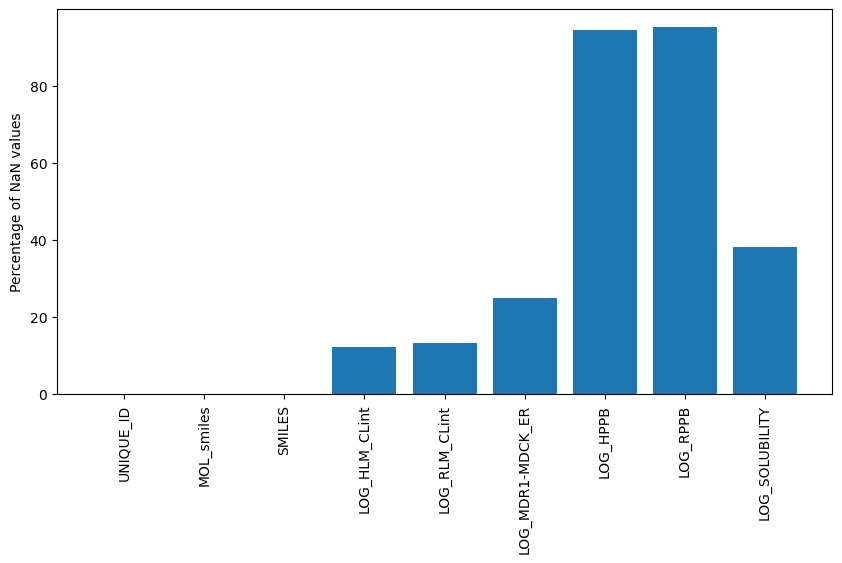

In [6]:
# calculate percentage of nan values in each column
nan_percent = data.isna().sum() / len(data) * 100
nan_percent
# plot a bar plot of the percentage of nan values in each column
plt.figure(figsize=(10, 5))
plt.bar(nan_percent.index, nan_percent.values)
plt.xticks(rotation=90)
plt.ylabel('Percentage of NaN values')
plt.show()

In [7]:
# percentage of nan values in all columns at the same time except for SMILES
nan_percent = data.iloc[:, 3:].isna().all(axis=1).sum() / len(data) * 100
nan_percent

0.0

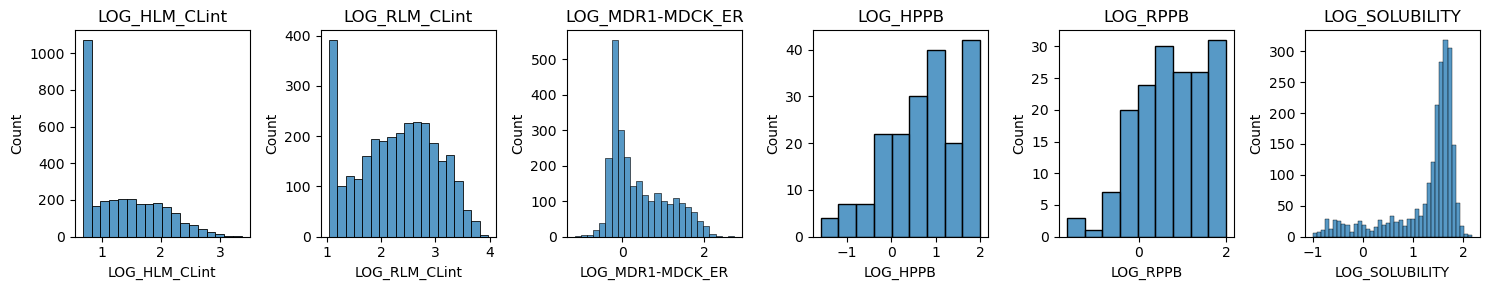

In [8]:
fig, ax = plt.subplots(1, 6, figsize=(15, 3))
for i, col in enumerate(data.columns[3:]):
    sns.histplot(data[col], ax=ax[i])
    ax[i].set_title(col)
plt.tight_layout()
plt.show()

In [9]:
data['smiles_std'] = data['SMILES'].apply(standardize)
data['smiles_std'].isna().sum()

4

In [10]:
data = data[data['smiles_std'].notna()].reset_index(drop=True)

In [ ]:
data

In [42]:
# data.to_csv('../data/asap/preproc/biogen-adme-fang-v1-std.tsv', sep='\t', index=False)

In [43]:
train = pd.read_csv('../data/asap/raw/train.tsv', sep='\t')
test = pd.read_csv('../data/asap/raw/test.tsv', sep='\t')

In [49]:
train["split"] = "train"
test["split"] = "test"
data["split"] = "external"
train["smiles_std"] = train["smiles"].apply(standardize)
test["smiles_std"] = test["smiles"].apply(standardize)
all_data = pd.concat([train, test, data]).reset_index(drop=True)

In [50]:
def plot_correlations(data, columns):
    # plot a grid of scatter plots purely with seaborn and add correlation coefficients
    g = sns.PairGrid(data[columns], diag_sharey=False)
    g.map_lower(sns.regplot, scatter_kws={'alpha': 0.5})
    g.map_upper(sns.regplot, scatter_kws={'alpha': 0.5})
    g.map_diag(sns.histplot)

    # iterate over plots and add correlation coefficients as scalar values to the scatter plots
    for (i, col1), (j, col2) in product(enumerate(columns), repeat=2):
        r_coeff = data[col1].corr(data[col2])
        ax = g.axes[i, j]
        ax.text(0.1, 0.9, f'r = {r_coeff:.2f}', 
                ha='left', va='top', 
                transform=ax.transAxes,  # Use axis coordinates
                fontsize=10,
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=0.2),  # Added padding
                color='black', zorder=10)  # Ensure text appears on top

    plt.tight_layout()
    plt.show()

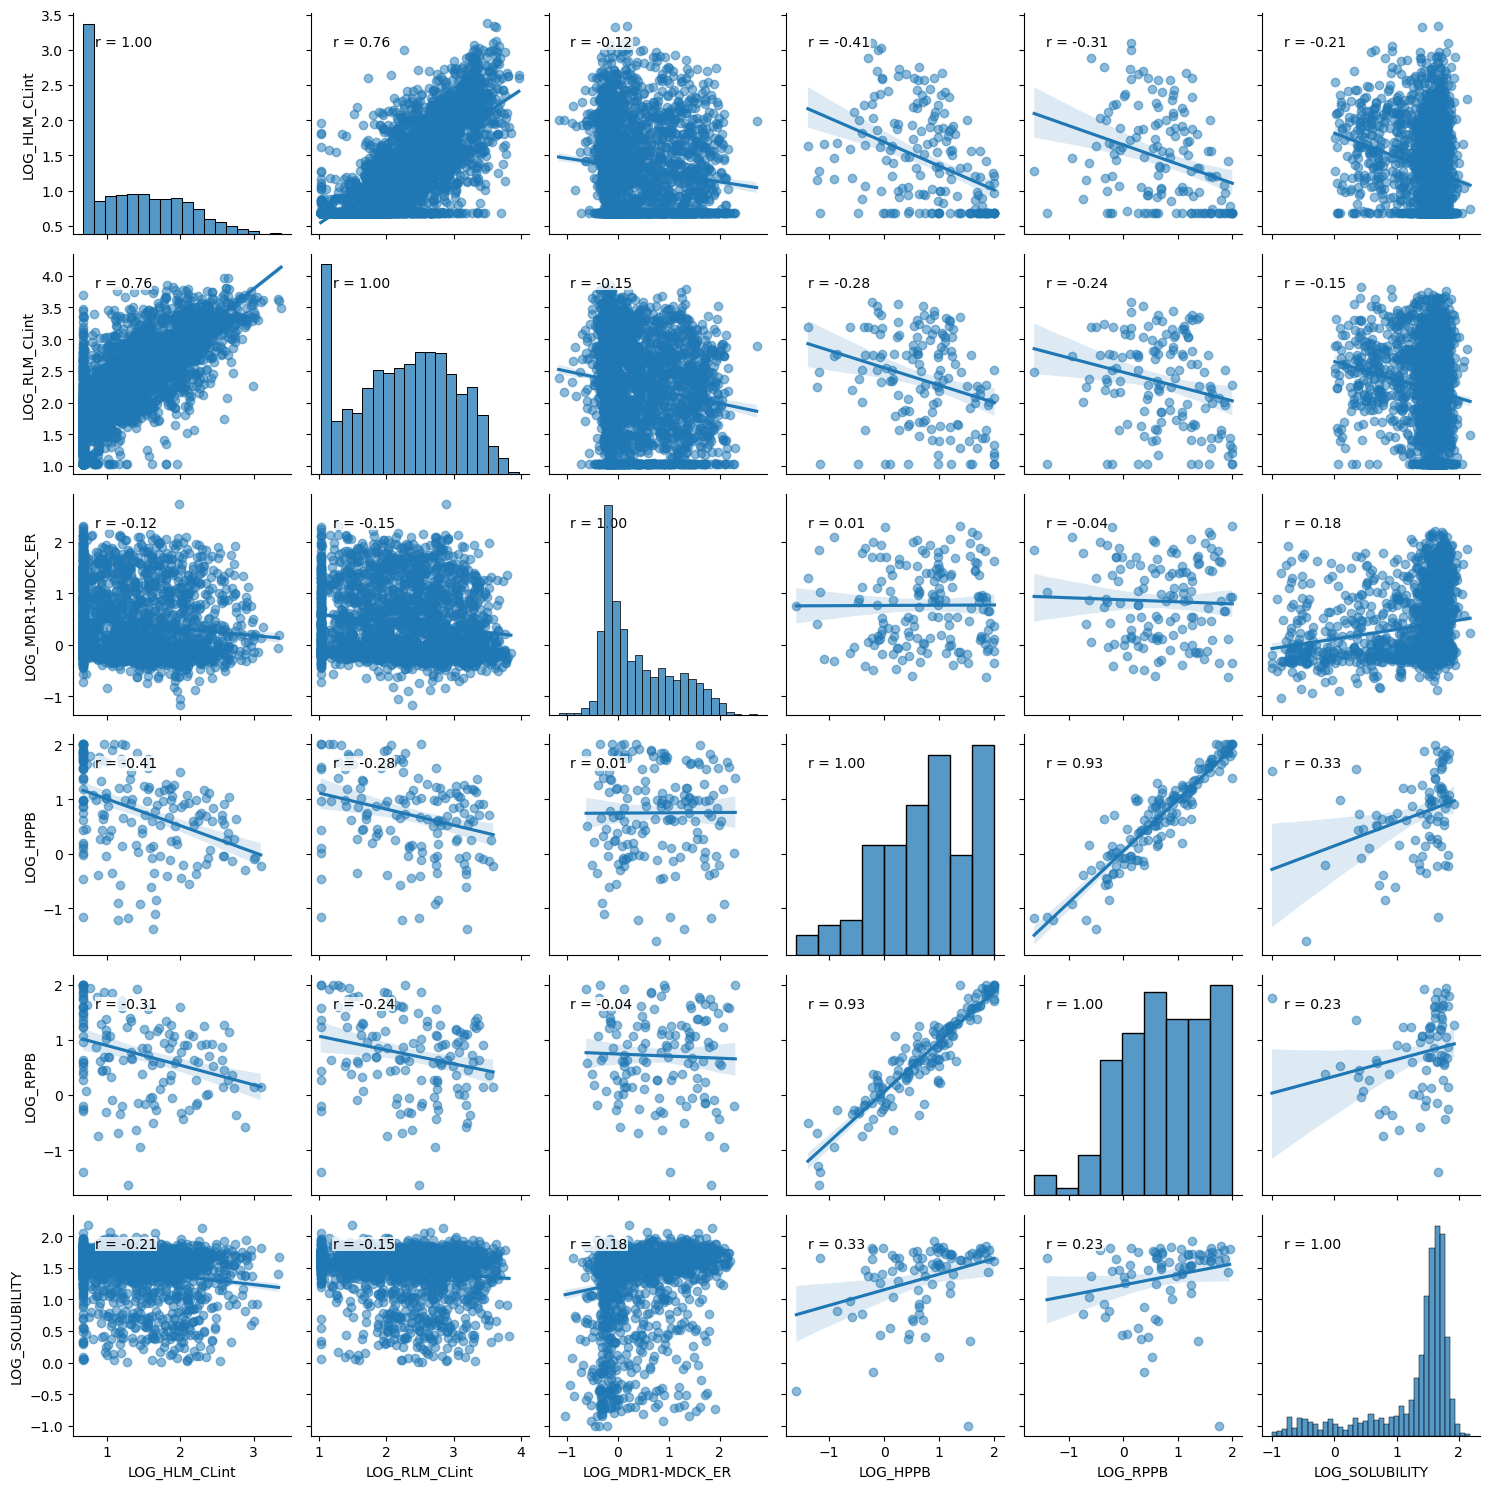

In [51]:
plot_correlations(data, ['LOG_HLM_CLint', 'LOG_RLM_CLint', 'LOG_MDR1-MDCK_ER', 'LOG_HPPB', 'LOG_RPPB', 'LOG_SOLUBILITY'])

In [53]:
ecfp = np.array(all_data['smiles_std'].apply(partial(ECFP_from_smiles, use_chirality=True)).tolist())

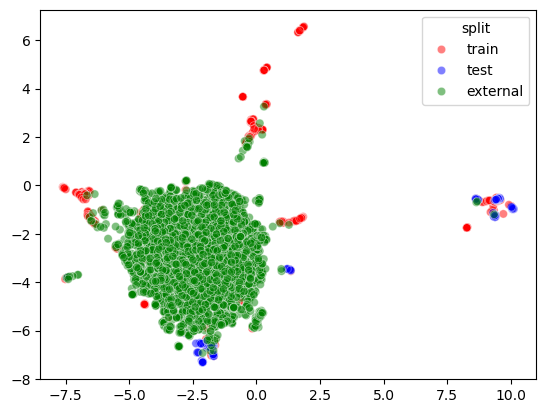

In [ ]:
ecfp_umap = umap.UMAP(
    n_components=2, random_state=RANDOM_STATE, n_jobs=1, metric='jaccard'
).fit_transform(ecfp)
sns.scatterplot(
    data=all_data,
    x=ecfp_umap[:, 0], y=ecfp_umap[:, 1], 
    hue='split',
    palette={'external': 'green', 'train': 'red', 'test': 'blue'},
    alpha=0.5
);